<a href="https://colab.research.google.com/github/JamesHemmings/TensorFLow_Binary_Classification_model/blob/main/James_binary_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import wmi
computer = wmi.WMI()
computer_info = computer.Win32_ComputerSystem()[0]
os_info = computer.Win32_OperatingSystem()[0]
proc_info = computer.Win32_Processor()[0]
gpu_info = computer.Win32_VideoController()[0]

os_name = os_info.Name.encode('utf-8').split(b'|')[0]
os_version = ' '.join([os_info.Version, os_info.BuildNumber])
system_ram = float(os_info.TotalVisibleMemorySize) / 1048576  # KB to GB

print(f"tensorflow version:{tf.__version__}\n")


if tf.config.list_physical_devices("GPU"):
    print('GPU: {0}'.format(gpu_info.Name))
    print('CPU: {0}'.format(proc_info.Name))

else:
    print("no gpu available\n")
    print('CPU:{0}'.format(proc_info.Name))

tensorflow version:2.9.1

GPU: NVIDIA GeForce RTX 3080 Ti
CPU: AMD Ryzen 7 5800X 8-Core Processor             


In [2]:
#getting data
import os

for dirpath,dirnames,filenames in os.walk("Documents/james_recognition_model_data"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}")

there are 3 directories and 0 in Documents/james_recognition_model_data
there are 2 directories and 0 in Documents/james_recognition_model_data\test
there are 0 directories and 11 in Documents/james_recognition_model_data\test\james
there are 0 directories and 16 in Documents/james_recognition_model_data\test\not_james
there are 0 directories and 2 in Documents/james_recognition_model_data\testing_photos
there are 2 directories and 0 in Documents/james_recognition_model_data\train
there are 0 directories and 75 in Documents/james_recognition_model_data\train\james
there are 0 directories and 137 in Documents/james_recognition_model_data\train\not_james


In [3]:
#creating data loaders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_dir = "Documents/james_recognition_model_data/train"
test_dir = "Documents/james_recognition_model_data/test"

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dategen = ImageDataGenerator(rescale = 1/255.)
test_dategen = ImageDataGenerator(rescale = 1/255.)

print("training images:")
train_data = train_dategen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")
print("testing images:")
test_data = test_dategen.flow_from_directory(test_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

training images:
Found 212 images belonging to 2 classes.
testing images:
Found 27 images belonging to 2 classes.


In [4]:
#setting up callbacks
import datetime

def create_tensorboard_callback(dir_name, project_name):
  log_dir = f"{dir_name}/{project_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

  print(f"TensorBoard log files saved to:{log_dir}")

  return tensorboard_callback

In [5]:
#importing model from tensorflow hub
efficinetnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
#create model function
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

def create_model(model_url,num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer

  feature_extraction_layer = hub.KerasLayer(model_url,
                                            trainable= False,
                                            name="test",
                                            input_shape = IMAGE_SHAPE+(3,)) # define the input image shape (224,224,3) rgb

  model = tf.keras.Sequential(layers=[
                               feature_extraction_layer, # layer created above as base for model
                               layers.Dense(num_classes,activation="sigmoid") #reshape the output data to return data in shape required for our model
                               ])                                           
  return model

In [7]:
james_model = create_model(efficinetnet_url,1)

#compile

james_model.compile(loss="binary_crossentropy",
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics=["accuracy"])

In [8]:
james_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 test (KerasLayer)           (None, 1280)              4049564   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,845
Trainable params: 1,281
Non-trainable params: 4,049,564
_________________________________________________________________


In [36]:
history = james_model.fit(train_data,
                          epochs=5,
                          steps_per_epoch=len(train_data),
                          validation_data= test_data,
                          validation_steps=len(test_data)
                          )

Epoch 1/5
7/7 [==============================] - 6s 826ms/step - loss: 0.2132 - accuracy: 0.9434 - val_loss: 0.2846 - val_accuracy: 0.9630
Epoch 2/5
7/7 [==============================] - 5s 717ms/step - loss: 0.1889 - accuracy: 0.9575 - val_loss: 0.2682 - val_accuracy: 0.9630
Epoch 3/5
7/7 [==============================] - 5s 789ms/step - loss: 0.1700 - accuracy: 0.9623 - val_loss: 0.2554 - val_accuracy: 0.9630
Epoch 4/5
7/7 [==============================] - 5s 762ms/step - loss: 0.1546 - accuracy: 0.9717 - val_loss: 0.2473 - val_accuracy: 0.9630
Epoch 5/5
7/7 [==============================] - 5s 712ms/step - loss: 0.1414 - accuracy: 0.9717 - val_loss: 0.2393 - val_accuracy: 0.9630


In [49]:
#testing model with custom data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import numpy as np


def test_custom_image(model,img_path,train_dir=train_dir,img_size=IMAGE_SHAPE):
  """
  tests a custom image on a classification model

  Keyword arguments:
  model -- trained classification model object
  img_path -- path to image to be tested
  img_size -- size image needs to be reshaped to for model to work 
  """
  #import image
  img = tf.io.read_file(img_path)
  #convert image to tensor
  img = tf.image.decode_image(img)
  #resize
  img = tf.image.resize(img,size=list(img_size))
  #scale rgb values
  img = tf.expand_dims(img/255.,axis=0)

  #get class names
  data_dir = pathlib.Path(train_dir)
  class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
  # print(f"class names:{class_names}")

  #make prediction
  pred = model.predict(img,verbose=False);
  #get name of class that was predicted
  guess = class_names[round(pred[0][0])]

  #show image
  if round(pred[0][0]) == 0:
    plt.title(f"models prediction:{guess} with certainty of {round(100-pred[0][0]*100,2)}%")
  else:
    plt.title(f"models prediction:{guess} with certainty of {round(pred[0][0]*100,2)}%")
  plt.axis("off")
  plt.imshow(mpimg.imread(img_path))
  


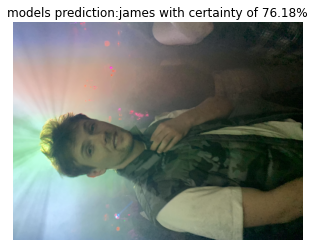

In [50]:
test_custom_image(model=james_model,img_path="Documents/james_recognition_model_data/testing_photos/j.JPG",train_dir=train_dir)

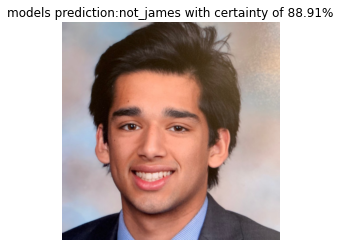

In [51]:
test_custom_image(model=james_model,img_path="Documents/james_recognition_model_data/testing_photos/m.jpeg",train_dir=train_dir)

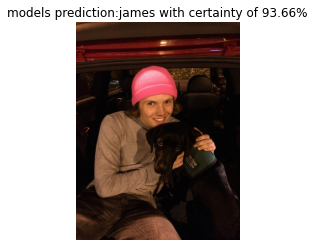

In [52]:
 test_custom_image(model=james_model,img_path="Documents/james_recognition_model_data/testing_photos/j1.JPG",train_dir=train_dir)